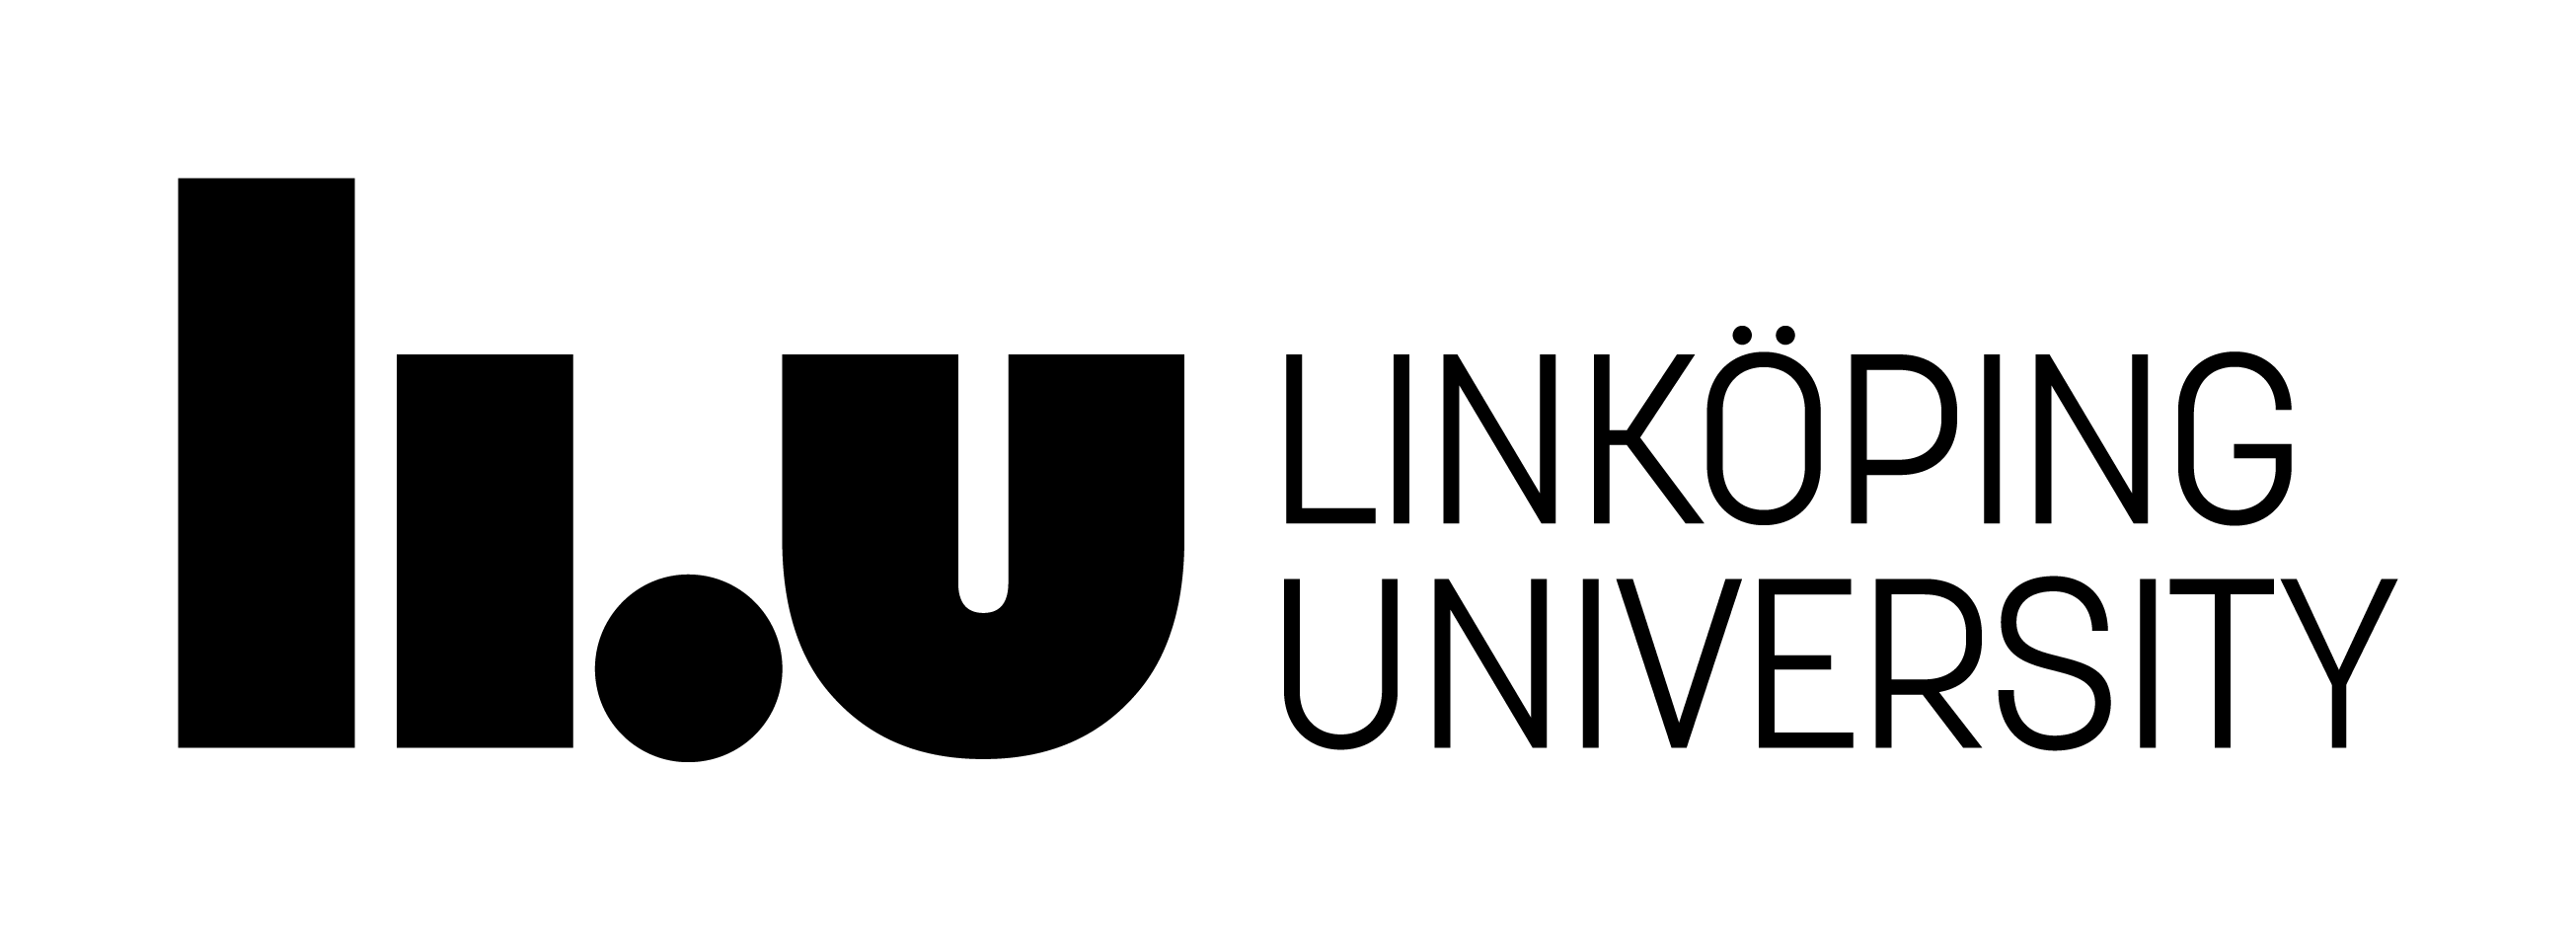
## Linkoping University: TDDC17 Artificial Intelligence
---



**Lab5: Deep Learning**

**Lab5.2: Implement a simple Multi-Layer Perceptron: Learn how to implement activation function, forward/backprop, SGD**

  In this assignment, you will learn how to implement a MLP. We will use the deep learning library PyTorch, which is well-known for its ease of use.
 

## Instaling and Loading packages

In [ ]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip3 install Pillow matplotlib


In [2]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

seed = 1234
np.random.seed(seed)

use_gpu = torch.cuda.is_available()
device = torch.device("cuda:0" if use_gpu else "cpu")


print("Torch version: ", torch.__version__)
print("GPU Available: {}".format(use_gpu))

Matplotlib is building the font cache; this may take a moment.


Torch version:  2.8.0
GPU Available: False


## General MLP pipeline:

*   define a task and a dataset,
*   a model description to fit the data,
*   an evaluation metric to assess the performance of a model,
*   a cost function to be optimized,
*    an optimizer that adjusts the parameters of the model.

# I. Task Definition and Dataset

The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone on board, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others. Our task here is to to predict whether or not a passenger survived the sinking of the Titanic based on passenger data only. We will use the dataset available [at the following link]( https://github.com/afansi/winterschool18/blob/master/titanic3.csv?).

In [3]:
titanic_df = pd.read_csv(
    'https://github.com/afansi/winterschool18/blob/master/titanic3.csv?raw=true',
    sep='\t',
    index_col=None,
    na_values=['NA']
)

titanic_df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [4]:
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     1309 non-null   int64  
 1   survived   1309 non-null   int64  
 2   name       1309 non-null   object 
 3   sex        1309 non-null   object 
 4   age        1046 non-null   float64
 5   sibsp      1309 non-null   int64  
 6   parch      1309 non-null   int64  
 7   ticket     1309 non-null   object 
 8   fare       1308 non-null   float64
 9   cabin      295 non-null    object 
 10  embarked   1307 non-null   object 
 11  boat       486 non-null    object 
 12  body       121 non-null    float64
 13  home.dest  745 non-null    object 
dtypes: float64(3), int64(4), object(7)
memory usage: 143.3+ KB


### I.1 Data pre-processing

Feature Selection: some features are not relevant to the task. For example : name, ticket, cabinet home.dest

Feature Encoding: Some features are categorial varibale(sex, pclass, embarqued) , we need to encode them using for example [One hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)

In [5]:
titanic_preprocess_df = pd.read_csv(
    'https://github.com/afansi/winterschool18/blob/master/titanic_prepocess.csv?raw=true',
    sep=',',
    index_col=None
)

titanic_preprocess_df.head()

,survived,pclass_1,pclass_2,pclass_3,sex_female,sex_male,age,sibsp,parch,fare,embarked_C,embarked_Q,embarked_S
0,1,1,0,0,1,0,29.0000,0,0,211.3375,0,0,1
1,1,1,0,0,0,1,0.9167,1,2,151.5500,0,0,1
2,0,1,0,0,1,0,2.0000,1,2,151.5500,0,0,1
3,0,1,0,0,0,1,30.0000,1,2,151.5500,0,0,1
4,0,1,0,0,1,0,25.0000,1,2,151.5500,0,0,1



### I.2 Train / validation / test split

We need to divide the dataset into three subsets:
- Train : subset of the data used to train the classifier model
- Validation: Used to valide the model
- Test: Used to evaluate the generalization performance of the model on unseen data



In [6]:

train, validate, test = np.split(
    titanic_preprocess_df.sample(frac=1, random_state=seed),
    [int(.6*len(titanic_preprocess_df)), int(.8*len(titanic_preprocess_df))])

# Remove the label column from X and create a label vectors.
X_train = train.drop(['survived'], axis=1).values
y_train = train['survived'].values

X_val = validate.drop(['survived'], axis=1).values
y_val = validate['survived'].values

X_test = test.drop(['survived'], axis=1).values
y_test = test['survived'].values



/Users/reevalex/Master/Term-1/TDDC17/group/labs/lab3_deep_learning/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


### I.3 Loading data in PyTorch

Since, we work with the PyTorch framework, we will need to load and convert the data into a PyTorch tensor using TensorDataset library

In [8]:
from torch.utils.data import TensorDataset

train_dataset = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())

val_dataset = TensorDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())

test_dataset = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

# II. Define a Model in Pytorch

We will use a MLP with the following properties (not unique): [MLP description](https://www.d2l.ai/chapter_multilayer-perceptrons/index.html)

- the input dimension of the model is 12,
- the output dimension of the model is 2,
- the number of hidden layers is 3,
- the dimensions of the hidden layers are 20, 40, 20 respectively,
- the activation function is a ReLu for all hidden layers.


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
seed = 1234
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [10]:
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        # Add fc1, fc2, fc3, and fc4 layers here
        self.fc1 = nn.Linear(12, 20)
        self.fc2 = nn.Linear(20, 40)
        self.fc3 = nn.Linear(40, 20)
        self.fc4 = nn.Linear(20, 2)

    def forward(self, x):
        # implement the forward pass here
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        out = self.fc4(x)
        return out

In [11]:
# Model definition
neural_net = NeuralNet()
neural_net = neural_net.to(device)

# II.1 Cost function

Pytorch has several loss functions: [pytorch loss function](https://pytorch.org/docs/stable/nn.html#loss-functions)

For classification problems, the usual cost function is cross-entropy. In PyTorch, it is defined by the function torch.nn.functional.cross_entropy. Cross entropy allows comparing a distribution Q with a reference distribution P .

In [12]:
import torch.nn.functional as F


def cost_function(prediction, target):
    loss = F.cross_entropy(prediction, target)
    return loss

# II.2 Backpropagation

In Pytorch, thanks to the automatic differentiation mechanism Autograd, it is possible to automatically calculate the gradient of the cost function and backpropagate it through the computational graph.

To do this, we only have to call the method backward() on the variable returned by the cost function, e.g., with


```
loss = cost_function(....)
loss.backward()
```





# II.3 Optimization

PyTorch provides a set of optimization methods (torch.optim) commonly used by the deep learning community. These methods include the following:

- SGD (Stochastic Gradient Descent) `torch.optim.SGD(net.parameters(), lr=learning_rate)`
    
- Adam (Adaptive Moment Estimation): a variant of the gradient descent method where the learning rate is adjusted for each parameter. This adjustment is based on the estimation of the first and second moments of the gradients. This optimizer has demonstrated excellent performance compared to SGD on many benchmarks.



In [13]:
import torch.optim as optim

optimizer = optim.Adam(neural_net.parameters(), lr=0.001)

# III. Train the model

We need some definitions:

- Epoch: a complete pass over the entire training dataset.
- Iteration: an update of the model parameters. Many iterations can occur before the end of an epoch.
- Mini-batch: a subset of training data used to estimate the average of gradients. In other words, at each iteration, a mini-batch is used.



In [14]:
#PyTorch offers a utility called torch.utils.data.DataLoader to load any dataset and automatically split it into mini-batches.

train_batch_size = 32  # number of data in a training batch.
eval_batch_size = 32   # number of data in an batch.


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)

val_loader   = torch.utils.data.DataLoader(val_dataset, batch_size=eval_batch_size, shuffle=False)
test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=eval_batch_size, shuffle=False)

In [15]:
# training procedure
def train(epoch, model, train_loader, optimizer, device):

    # activate the training mode
    model.train()

    torch.set_grad_enabled(True)

    total_loss = 0
    correct = 0

    # iteration over the mini-batches
    for batch_idx, (data, target) in enumerate(train_loader):

        # transfer the data on the chosen device
        data, target = data.to(device), target.to(device)

        # reinitialize the gradients to zero
        optimizer.zero_grad()

        # forward propagation on the data
        prediction = model(data)

        # compute the cost function w.r.t. the targets(use the cost_function)
        loss = cost_function(prediction, target)

        # execute the backpropagation
        loss.backward()

        # execute an optimization step
        optimizer.step()

        # accumulate the loss
        total_loss += loss.item()*len(data)

        # compute the number of correct predictions
        _, pred_classes = torch.max(prediction, dim=1)
        correct += pred_classes.eq(target.view_as(pred_classes)).sum().item()


    # compute the average cost per epoch
    mean_loss = total_loss/len(train_loader.dataset)

    # compute the accuracy
    acc = correct / len(train_loader.dataset)

    print('Train Epoch: {}   Avg_Loss: {:.5f}   Acc: {}/{} ({:.3f}%)'.format(
        epoch, mean_loss, correct, len(train_loader.dataset),
        100. * acc))

    # return the average loss and the accuracy
    return mean_loss, acc

In [18]:
# Evaluation procedure

def evaluate(model, eval_loader, device):

    # activate the evaluation mode
    model.eval()

    total_loss = 0
    correct = 0

    with torch.no_grad():

        # iterate over the batches
        for batch_idx, (data, target) in enumerate(eval_loader):

            # transfer the data on the chosen device
            data, target = data.to(device), target.to(device)

            # forward propagation on the data
            prediction = model(data)

            # compute the cost function w.r.t. the targets(use cost_function)
            loss = cost_function(prediction, target)

            # accumulate the loss
            total_loss += loss.item()*len(data)

            # compute the number of correct predictions en sortie)
            _, pred_classes = torch.max(prediction, dim=1)
            correct += pred_classes.eq(target.view_as(pred_classes)).sum().item()


    # compute the average cost per epoch
    mean_loss = total_loss/len(eval_loader.dataset)

    # compute the accuracy
    acc = correct / len(eval_loader.dataset)

    print('Eval:  Avg_Loss: {:.5f}   Acc: {}/{} ({:.3f}%)'.format(
        mean_loss, correct, len(eval_loader.dataset),
        100. * acc))

    # return the average loss and the accuracy
    return mean_loss, acc



#IV. Putting everything together

In [19]:
# maximum number of epoch
numEpochs = 200

# Saving frequency
checkpoint_freq = 10

# Directory for data backup
path = './'

# Accumulators of average costs obtained per epoch
train_losses = []
val_losses = []

# Performance accumulators per epoch
train_accuracies = []
val_accuracies = []

# Model definition
neural_net = NeuralNet()

# Load the model on the chosen device
neural_net = neural_net.to(device)

# Optimizer definition
optimizer = optim.Adam(neural_net.parameters(), lr=0.001)
# optimizer = optim.SGD(neural_net.parameters(), lr=0.001)


# Learning loop
for epoch in range(1, numEpochs + 1):

    # train the model with the train dataset
    train_loss, train_acc = train(epoch, neural_net, train_loader, optimizer, device)

    # evaluate the model with the validation dataset
    val_loss, val_acc = evaluate(neural_net, val_loader, device)

    # Save the costs obtained
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Save the performances
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)



Train Epoch: 1   Avg_Loss: 0.69293   Acc: 328/625 (52.480%)
Eval:  Avg_Loss: 0.65896   Acc: 144/209 (68.900%)
Train Epoch: 2   Avg_Loss: 0.64543   Acc: 402/625 (64.320%)
Eval:  Avg_Loss: 0.64240   Acc: 142/209 (67.943%)
Train Epoch: 3   Avg_Loss: 0.63790   Acc: 416/625 (66.560%)
Eval:  Avg_Loss: 0.62430   Acc: 146/209 (69.856%)
Train Epoch: 4   Avg_Loss: 0.62793   Acc: 427/625 (68.320%)
Eval:  Avg_Loss: 0.61653   Acc: 146/209 (69.856%)
Train Epoch: 5   Avg_Loss: 0.61643   Acc: 424/625 (67.840%)
Eval:  Avg_Loss: 0.59787   Acc: 146/209 (69.856%)
Train Epoch: 6   Avg_Loss: 0.60806   Acc: 436/625 (69.760%)
Eval:  Avg_Loss: 0.59290   Acc: 148/209 (70.813%)
Train Epoch: 7   Avg_Loss: 0.60101   Acc: 439/625 (70.240%)
Eval:  Avg_Loss: 0.58099   Acc: 145/209 (69.378%)
Train Epoch: 8   Avg_Loss: 0.58962   Acc: 448/625 (71.680%)
Eval:  Avg_Loss: 0.57588   Acc: 147/209 (70.335%)
Train Epoch: 9   Avg_Loss: 0.58140   Acc: 440/625 (70.400%)
Eval:  Avg_Loss: 0.57372   Acc: 146/209 (69.856%)
Train Epoc

In [ ]:
# Activate the evaluation mode
neural_net = neural_net.eval()

# Select the first 10 data points of the validation set
data, target = val_dataset[0:10]
data = data.to(device)

# Executing the neural network
output = neural_net(data)   # equivalent to neural_net.forward(data)

# Transform the output into a probability distribution with a softmax function
output_proba = F.softmax(output, dim=1)

# Print the probability
torch.set_printoptions(sci_mode=False)
print(output_proba)

tensor([[9.3290e-01, 6.7100e-02],
        [5.9162e-01, 4.0838e-01],
        [5.2696e-01, 4.7304e-01],
        [4.3046e-01, 5.6954e-01],
        [7.0078e-01, 2.9922e-01],
        [8.8401e-01, 1.1599e-01],
        [8.4137e-01, 1.5863e-01],
        [6.0031e-01, 3.9969e-01],
        [2.0135e-04, 9.9980e-01],
        [3.1547e-02, 9.6845e-01]], grad_fn=<SoftmaxBackward0>)


In [23]:
# For each example, retrieve the class with the highest probability.
_, prediction = torch.max(output_proba, dim=1)

print("Model predictions")
print(prediction)

print("Targets")
print(target)

Model predictions
tensor([0, 0, 0, 1, 0, 0, 0, 0, 1, 1])
Targets
tensor([0, 0, 0, 0, 0, 0, 0, 1, 1, 1])


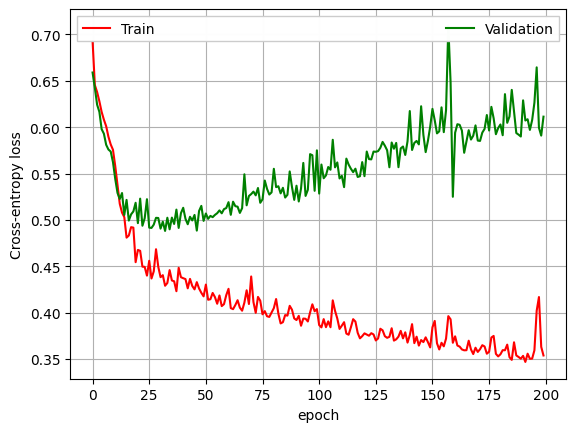

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

x = list(range(len(train_losses)))

ax = plt.subplot(111)
plt.plot(x, train_losses, 'r', label="Train")
plt.plot(x, val_losses, 'g', label="Validation")
plt.xlabel('epoch')
plt.ylabel('Cross-entropy loss')
plt.grid()
leg = plt.legend(loc='best', ncol=2, mode="expand", shadow=False, fancybox=False)
leg.get_frame().set_alpha(0.99)

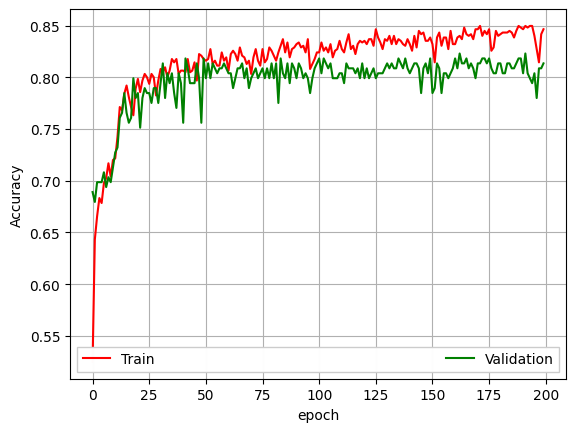

In [25]:
x = list(range(len(train_accuracies)))

ax = plt.subplot(111)
plt.plot(x, train_accuracies, 'r', label="Train")
plt.plot(x, val_accuracies, 'g', label="Validation")
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.grid()
leg = plt.legend(loc='best', ncol=2, mode="expand", shadow=False, fancybox=False)
leg.get_frame().set_alpha(0.99)

**Questions:**

- What do you observe in the previous graphs?
- At which epoch is it interesting to retrieve the model parameters for inference?

#V. How to evaluate a model on the test set?

In [ ]:
test_loss, test_acc = evaluate(neural_net, test_loader, device)

**Questions**:

*   Compare validation and test metrics.
*   What technic can we use to get a more robust estimate




Sources:

- https://github.com/mila-iqia/ivado-mila-dl-school-2019
- https://www.kaggle.com/datasets/yasserh/titanic-dataset
- Dive into Deep learning [link](https://www.d2l.ai/chapter_multilayer-perceptrons/index.html)